In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from scipy import ndimage
from skimage import color, util, transform
from scipy.fft import fft, fftfreq

In [2]:
IMAGES_PATH = os.path.join('dataset', 'images')

In [3]:
im = np.array(Image.open(os.path.join(IMAGES_PATH, os.listdir(IMAGES_PATH)[0])))
im.shape

(256, 256, 3)

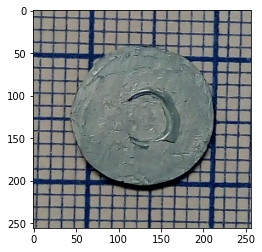

In [4]:
plt.imshow(im)
plt.show()

In [5]:
def norm(A):
    return (A-A.min())/(A.max()-A.min())

def get_topol(image, f=np.sum, normalize=True):
    X_values, Y_values = f(image, axis=0), f(image, axis=1)
    if normalize: return norm(X_values), norm(Y_values)
    else: return X_values, Y_values

# Contornos

## Gradiente e Laplaciano

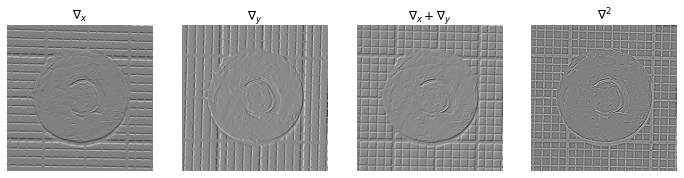

In [55]:
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
dX, dY = np.gradient(color.rgb2gray(im))
images = (dX, dY, dX+dY, np.gradient(dX)[0] + np.gradient(dY)[1])
labels = (r'$\nabla_x$', r'$\nabla_y$', r'$\nabla_x + \nabla_y$', r'$\nabla^2$')
for ax, cimg, label in zip(axs, images, labels):
    ax.imshow(cimg, cmap='gray')
    ax.axis('off')
    ax.set_title(label)
plt.show()

## Gaussiano

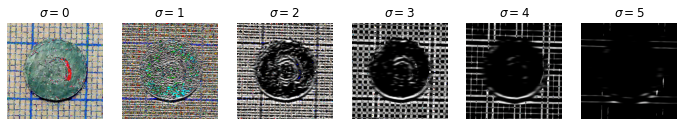

In [61]:
fig, axs = plt.subplots(1, 6, figsize=(12, 3))

for k, ax in enumerate(axs):
    ax.imshow(ndimage.gaussian_laplace(im, k))
    ax.set_title(r'$\sigma = {}$'.format(k))
    ax.axis('off')

plt.show()

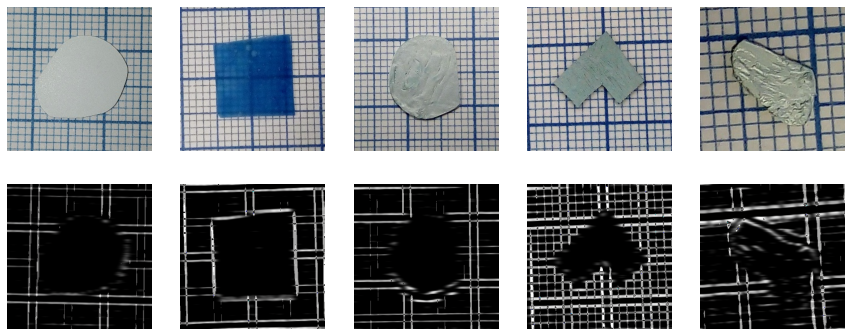

In [6]:
nimgs = 5
fig, axs = plt.subplots(2, 5, figsize=(3*nimgs, 6))
for i, rdfilename in enumerate(np.random.choice(os.listdir(IMAGES_PATH), 5)):
    rdimg = np.array(Image.open(os.path.join(IMAGES_PATH, rdfilename)))
    axs[0][i].imshow(rdimg)
    #axs[1][i].imshow(ndimage.gaussian_laplace(rdimg, 3))
    axs[1][i].imshow(ndimage.gaussian_laplace(rdimg, 4))
    for ax in axs[:, i]: ax.axis('off')
plt.show()

# Sombra e luz

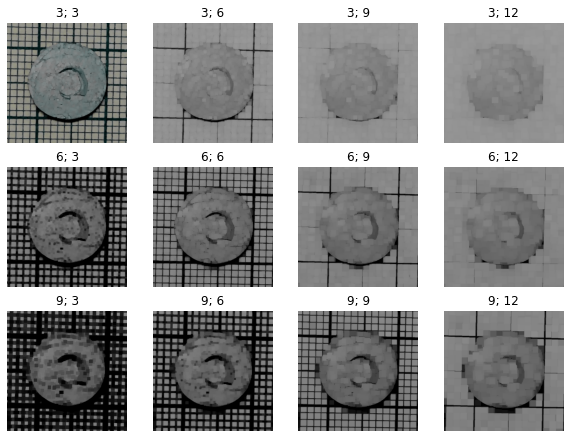

In [11]:
w, h = 4, 3
fig, axs = plt.subplots(h, w, figsize=(w*2.5, h*2.5))
for i in range(h):
    for j in range(w):
        min_size = (i+1)*3
        max_size = (j+1)*3
        axs[i][j].imshow(ndimage.maximum_filter(ndimage.minimum_filter(im, size=min_size), size=max_size))
        axs[i][j].set_title(f'{min_size}; {max_size}')
        axs[i][j].axis('off')
plt.show()

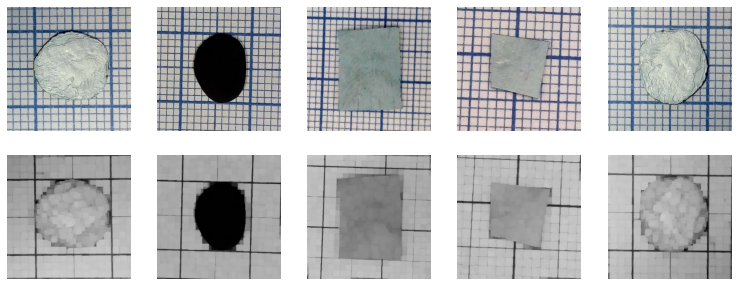

In [23]:
nimgs = 5
fig, axs = plt.subplots(2, nimgs, figsize=(13, 5))
for i, rdfilename in enumerate(np.random.choice(os.listdir(IMAGES_PATH), 5)):
    rdimg = np.array(Image.open(os.path.join(IMAGES_PATH, rdfilename)))
    axs[0][i].imshow(rdimg)
    axs[1][i].imshow(ndimage.maximum_filter(ndimage.minimum_filter(rdimg, size=6), size=9))
    for ax in axs[:, i]: ax.axis('off')
plt.show()

# Morfologia

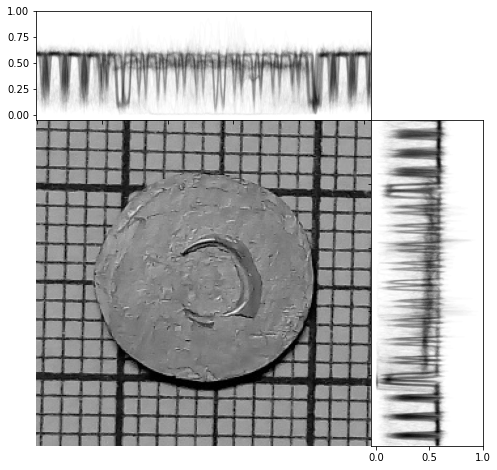

In [60]:
W, w = 8, 2
fig = plt.figure(figsize=(W, W))
gs = fig.add_gridspec(2, 2,  width_ratios=(W-w, w), height_ratios=(w, W-w), wspace=0, hspace=0)
ax = fig.add_subplot(gs[1, 0])
ax.axis('off')
ax_x = fig.add_subplot(gs[0, 0], sharex=ax)
ax_x.tick_params(axis="x", labelbottom=False)
ax_y = fig.add_subplot(gs[1, 1], sharey=ax)
ax_y.tick_params(axis="y", labelleft=False)

t = range(len(im))
g_im = color.rgb2gray(im)
ax.imshow(g_im, cmap='gray', aspect='auto')
for i in t:
    ax_x.plot(t, g_im[i], c='k', alpha=0.01)
    ax_y.plot(g_im[:, i], t, c='k', alpha=0.01)

plt.show()

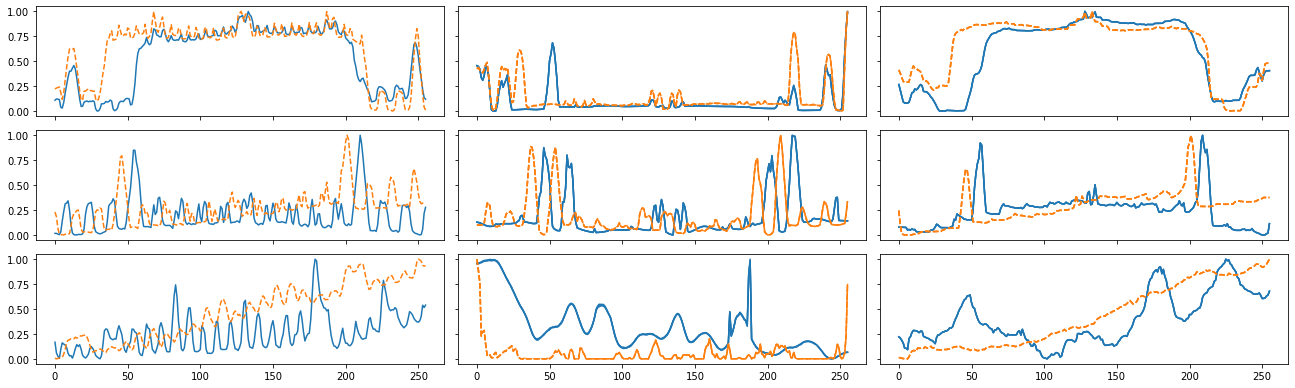

In [6]:
fig, axs = plt.subplots(3, 3, figsize=(18, 5.5), tight_layout=True, sharey=True, sharex=True)
fig.subplots_adjust(hspace=0, wspace=0)

rdimages = []
outs = []
for i, rdfilename in enumerate(np.random.choice(os.listdir(IMAGES_PATH), 3)):
    rdimg = np.array(Image.open(os.path.join(IMAGES_PATH, rdfilename)))
    rdimages.append(rdimg)
    t = range(len(rdimg))
    vimgs = [
        color.rgb2gray(rdimg), 
        ndimage.gaussian_laplace(rdimg, 4), 
        ndimage.maximum_filter(ndimage.minimum_filter(rdimg, size=9), size=12)
    ]
    outs.append([])
    for j, vIm in enumerate(vimgs):
        if j != 1: vIm = util.invert(vIm)
        X, Y = get_topol(vIm)
        outs[-1].append(np.meshgrid(X, Y))
        ax = axs[i][j]
        ax.plot(t, X, c='tab:blue')
        ax.plot(t, Y, '--', c='tab:orange')

plt.show()

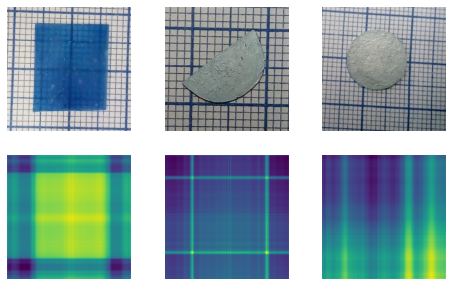

In [7]:
fig, axs = plt.subplots(2, 3, figsize=(8, 5))
f = lambda a, b: a+b
for i, (rdimg, (reimg, glimg, mhimg)) in enumerate(zip(rdimages, outs)):
    axs[0, i].imshow(rdimg)
    axs[0, i].axis('off')
    axs[1, i].imshow(f(*mhimg))
    axs[1, i].axis('off')
plt.show()

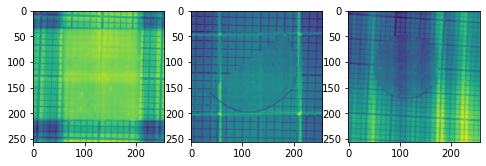

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(8, 5))
f = lambda a, b: a+b
for i, (rdimg, (reimg, glimg, mhimg)) in enumerate(zip(rdimages, outs)):
    axs[i].imshow(color.rgb2gray(rdimg) + transform.resize(f(*mhimg), (256, 256)))
plt.show()

# Cor

## HSV 

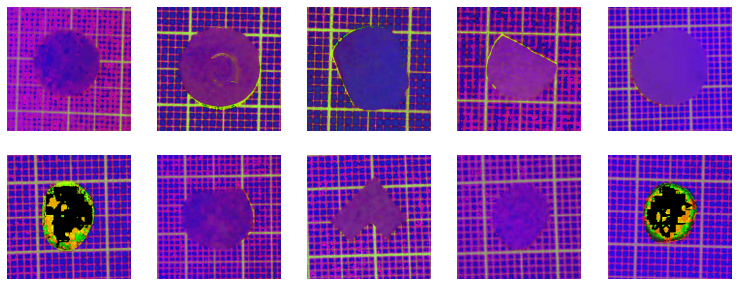

In [63]:
fig, axs = plt.subplots(2, 5, figsize=(13, 5))
for ax in axs.flat:
    rdimg = np.array(Image.open(os.path.join(IMAGES_PATH, np.random.choice(os.listdir(IMAGES_PATH)))))
    ax.imshow(color.rgb2hsv(rdimg))
    ax.axis('off')
plt.show()

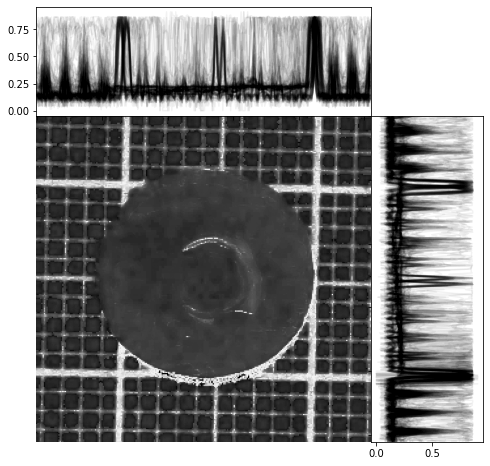

In [77]:
W, w = 8, 2
fig = plt.figure(figsize=(W, W))
gs = fig.add_gridspec(2, 2,  width_ratios=(W-w, w), height_ratios=(w, W-w), wspace=0, hspace=0)
ax = fig.add_subplot(gs[1, 0])
ax.axis('off')
ax_x = fig.add_subplot(gs[0, 0], sharex=ax)
ax_x.tick_params(axis="x", labelbottom=False)
ax_y = fig.add_subplot(gs[1, 1], sharey=ax)
ax_y.tick_params(axis="y", labelleft=False)

t = range(len(im))
g_im = color.rgb2gray(color.rgb2hsv(im))
ax.imshow(g_im, cmap='gray', aspect='auto')
for i in t:
    ax_x.plot(t, g_im[i], c='k', alpha=0.05)
    ax_y.plot(g_im[:, i], t, c='k', alpha=0.05)

plt.show()

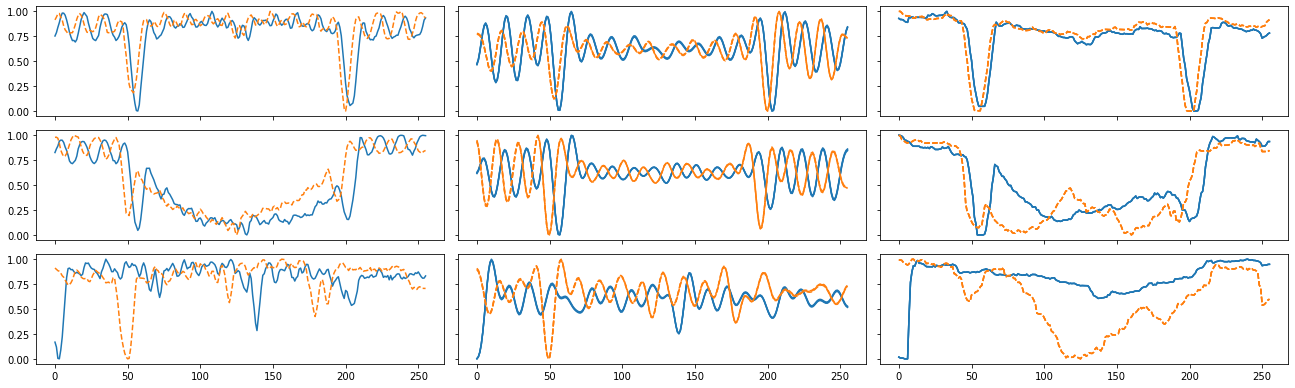

In [54]:
fig, axs = plt.subplots(3, 3, figsize=(18, 5.5), tight_layout=True, sharey=True, sharex=True)
fig.subplots_adjust(hspace=0, wspace=0)

rdimages = []
outs = []
for i, rdfilename in enumerate(np.random.choice(os.listdir(IMAGES_PATH), 3)):
    rdimg = color.rgb2hsv(np.array(Image.open(os.path.join(IMAGES_PATH, rdfilename))))
    rdimages.append(rdimg)
    t = range(len(rdimg))
    vimgs = [
        color.rgb2gray(rdimg), 
        ndimage.gaussian_laplace(rdimg, 4), 
        ndimage.maximum_filter(ndimage.minimum_filter(rdimg, size=9), size=12)
    ]
    outs.append([])
    for j, vIm in enumerate(vimgs):
        if j != 1: vIm = util.invert(vIm)
        X, Y = norm(np.sum(vIm, axis=0)), norm(np.sum(vIm, axis=1))
        outs[-1].append(np.meshgrid(X, Y))
        ax = axs[i][j]
        ax.plot(t, X, c='tab:blue')
        ax.plot(t, Y, '--', c='tab:orange')

plt.show()

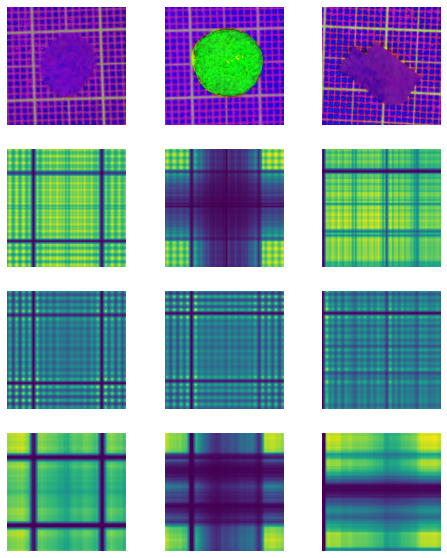

In [55]:
fig, axs = plt.subplots(4, 3, figsize=(8, 10))
f = lambda a, b: a*b
for i, (rdimg, (re, gl, mh)) in enumerate(zip(rdimages, outs)):
    axs[0, i].imshow(rdimg)
    axs[0, i].axis('off')
    axs[1, i].imshow(f(*re))
    axs[1, i].axis('off')
    axs[2, i].imshow(f(*gl))
    axs[2, i].axis('off')
    axs[3, i].imshow(f(*mh))
    axs[3, i].axis('off')
plt.show()

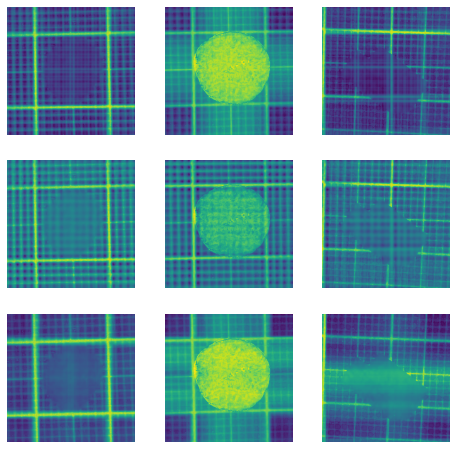

In [56]:
fig, axs = plt.subplots(3, 3, figsize=(8, 8))
for i, (rdimg, (re, gl, mh)) in enumerate(zip(rdimages, outs)):
    axs[0, i].imshow(color.rgb2gray(rdimg) - f(*re))
    axs[0, i].axis('off')
    axs[1, i].imshow(color.rgb2gray(rdimg) - transform.resize(f(*gl), (256, 256)))
    axs[1, i].axis('off')
    axs[2, i].imshow(color.rgb2gray(rdimg) - transform.resize(f(*mh), (256, 256)))
    axs[2, i].axis('off')
plt.show()

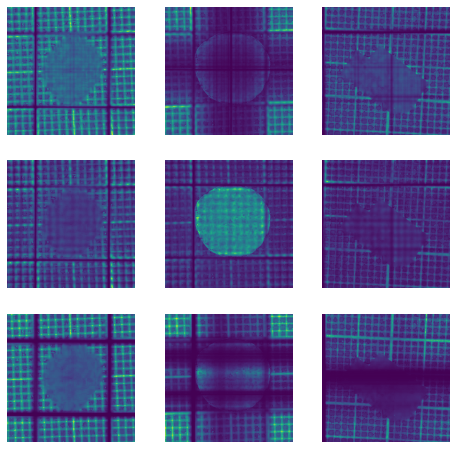

In [57]:
fig, axs = plt.subplots(3, 3, figsize=(8, 8))
for i, (rdimg, (re, gl, mh)) in enumerate(zip(rdimages, outs)):
    axs[0, i].imshow(color.rgb2gray(rdimg) * f(*re))
    axs[0, i].axis('off')
    axs[1, i].imshow(color.rgb2gray(rdimg) * transform.resize(f(*gl), (256, 256)))
    axs[1, i].axis('off')
    axs[2, i].imshow(color.rgb2gray(rdimg) * transform.resize(f(*mh), (256, 256)))
    axs[2, i].axis('off')
plt.show()